<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/blob/path_manager/model_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
from google.colab import drive
import pickle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [2]:
# PEP 8
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

# Setup paths

In [3]:
# %%pycodestyle
from dataclasses import dataclass
from dataclasses import field
import os


@dataclass
class PathManager:
    competition_path: str
    preprocessing_trial: int
    models_trial: int

    def __post_init__(self):
        self.data_root_path = os.path.join(self.competition_path, 'Data')
        self.models_root_path = os.path.join(self.competition_path, 'Models')

        self.data_trial_path = os.path.join(
            self.data_root_path,
            f'preproc_trial_{self.preprocessing_trial}'
        )
        self.models_trial_path = os.path.join(
            self.models_root_path,
            f'trial_{self.models_trial}'
        )

    @property
    def train_path(self):
        return os.path.join(self.data_root_path, 'train.csv')

    @property
    def test_path(self):
        return os.path.join(self.data_root_path, 'test.csv')

    def _create_path(self, path):
        if not os.path.isdir(path):
            os.mkdir(path)
        else:
            print(f'{path} already exists')

    def save_to_csv(self, array_, path_, file_name_):
        df = pd.DataFrame(array_)
        df.to_csv(os.path.join(path_, file_name_))

    def setup_paths(self):
        # precondition
        assert os.path.isdir(self.data_root_path), print(self.data_root_path)
        assert os.path.isdir(self.models_root_path), \
            print(self.models_root_path)

        self._create_path(self.data_trial_path)
        self._create_path(self.models_trial_path)

    def save_models(self, sklearn_models_dict_):
        '''
        For each model in the dictionary, create a folder.
        Save pickle file there. If model (or folder) already exists -
        overrides all files
        '''
        for model_name, sklearn_model in sklearn_models_dict_.items():
            folder_path = os.path.join(
                self.models_trial_path, model_name
            )
            self._create_path(folder_path)
            model_filename = model_name + '.sav'
            pickle.dump(
                sklearn_model,
                open(
                    os.path.join(folder_path, model_filename),
                    'w+b'
                ),
            )

    def load_models(self, models_subfolders_=[]):
        '''
        1. Goes to self.models_trial_path
        2. If models_names=[] - downloads all
           models from their subfolders.
        3. models_names must contain names of subfolders on
           google drive!
        '''

        # precondition
        assert os.path.isdir(self.models_trial_path), \
            print(self.models_trial_path)

        available_models_subfolders = os.listdir(self.models_trial_path)
        if models_subfolders_:
            models_to_download = models_subfolders_
        else:
            # Download everything
            models_to_download = available_models_subfolders

        res = {}
        for model_subfolder in models_to_download:
            # file name coincides with folder name
            file_name = f'{model_subfolder}.sav'
            full_path = os.path.join(
                self.models_trial_path,
                model_subfolder,
                file_name
            )

            loaded_model = pickle.load(
                open(full_path, 'rb')
            )
            res[model_subfolder] = loaded_model
        return res


pep8(_ih)

In [4]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'

COMPETITION_PATH = gdrive_path + 'ML/Competitions/5.RestaurantRevenue/'
PREPROC_TRIAL = 1
MODELS_TRIAL = 1

pep8(_ih)

Mounted at /content/gdrive



In [5]:
path_manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)

pep8(_ih)

# Download models

In [6]:
models = path_manager.load_models()

In [7]:
models

{'elastic_net_final': ElasticNet(alpha=0.5, l1_ratio=0.2),
 'random_forest': RandomForestRegressor(n_estimators=500),
 'RF': RandomForestRegressor(max_depth=11, n_estimators=300),
 'Elastic': ElasticNet(),
 'SVM reg': SVR()}

# Download data

In [17]:
df_test = pd.read_csv(
    os.path.join(
        path_manager.data_trial_path,
        'test_processed.csv'
    ),
    index_col=[0]
)

# subsample from train.csv for testing
df_test_sample = pd.read_csv(
    os.path.join(
        path_manager.data_trial_path,
        'test_sample_processed.csv'
    ),
    index_col=[0]
)

df_trainval = pd.read_csv(
    os.path.join(
        path_manager.data_trial_path,
        'trainval_sample_processed.csv'
    ),
    index_col=[0]
)

X_train_val = df_trainval.values[:, :-1]
Y_train_val = df_trainval.values[:, -1]

X_test_sample = df_test_sample.values[:, :-1]
Y_test_sample = df_test_sample.values[:, -1]

# Model mistake analysis

- From feature importance analysis, we see that the most important features are **opening year** and **city population**

# Feature importance

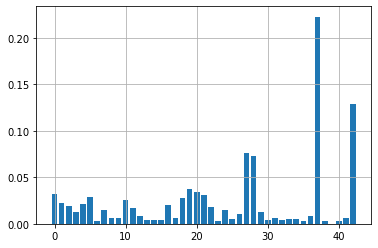

In [9]:
import numpy as np
import matplotlib.pyplot as plt

plt.bar(
    np.arange(len(models['RF'].feature_importances_)),
    models['RF'].feature_importances_
)
plt.grid()

pep8(_ih)

# Visualize trainval predictions

In [16]:
def visualize_regression_predictions(
        sklearn_models_dict_,
        X_,
        Y_,
        dataset_type_
):

    _, ax = plt.subplots()
    ax.plot(
        Y_,
        label=f'{dataset_type_} target'
    )

    for model_name, model in sklearn_models_dict_.items():
        predictions = model.predict(X_)
        ax.scatter(
            x=np.arange(len(predictions)),
            y=predictions,
            label=f'{model_name} predictions'
        )

    ax.set_xlabel('Dataset instance')
    ax.set_ylabel('Prediction')
    ax.set_title(f'Visualized predictons on {dataset_type_}')

    ax.legend()
    ax.grid()


pep8(_ih)

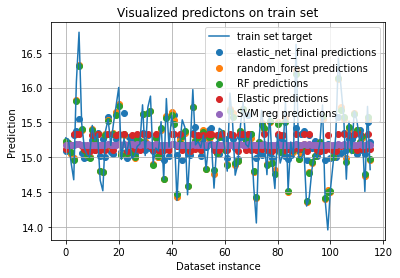

In [18]:
visualize_regression_predictions(
    models,
    X_=X_train_val,
    Y_=Y_train_val,
    dataset_type_='train set'
)

# Selecting final model

- I select the best model, based on average cross validation score among fine-tuned models. At the same time, i track that this model does not overfit the trainset, and average cross-validation performance is comparable with train metrics

In [24]:
def print_model_cv_scores(sklearn_models_dict_, X_, Y_, cv_, scoring_):
    res = {}
    for name, model in sklearn_models_dict_.items():
        scores = cross_val_score(
            model,
            X_,
            Y_,
            cv=cv_,
            scoring=scoring_
        )
        res[name] = scores
    
    # Sort the dict
    sorted_res = {
        k:v for \
        k, v in sorted(res.items(), key = lambda item: np.mean(item[1]))
    }
    for model_name, scores in sorted_res.items():
        print(f'Model: {model_name}, mean: {np.mean(scores)}, std: {np.std(scores)}')

    return sorted_res

In [25]:
_ = print_model_cv_scores(
    models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=7,
    scoring_='neg_mean_squared_error'
)

Model: SVM reg, mean: -0.23975755066794463, std: 0.10254520924351965
Model: Elastic, mean: -0.21569093211351922, std: 0.10074172443016455
Model: elastic_net_final, mean: -0.20073170318480518, std: 0.08848660198096124
Model: RF, mean: -0.19363818704778796, std: 0.06803266748147563
Model: random_forest, mean: -0.19217706219245537, std: 0.06907354087088997


In [33]:
def plot_cv_results(
    sklearn_models_dict_,
    X_,
    Y_,
    cv_,
    scoring_,
    to_put_minus_=False
):

    for model_name, model in sklearn_models_dict_.items():
        cv_res = cross_validate(
            model,
            X_,
            Y_,
            cv=cv_,
            scoring=scoring_,
            return_train_score=True
        )
        _, ax = plt.subplots()
        x = np.arange(len(cv_res['test_score']))
        width = 0.5
        if to_put_minus_:
            train_score = -cv_res['train_score']
            test_score = -cv_res['test_score']
        else:
            train_score = cv_res['train_score']
            test_score = cv_res['test_score']

        ax.bar(x - width / 2, test_score, width, label='validation')
        ax.bar(x + width / 2, train_score, width, label='train')

        ax.set_title(f'Results for {model_name}')
        ax.set_xlabel(f'CV fold number')
        ax.set_ylabel(f'Metrics: {scoring_}')

        ax.legend()
        ax.grid()


pep8(_ih)

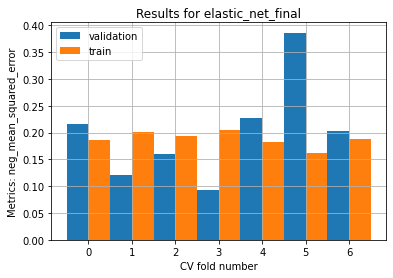

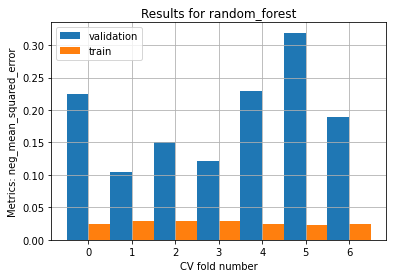

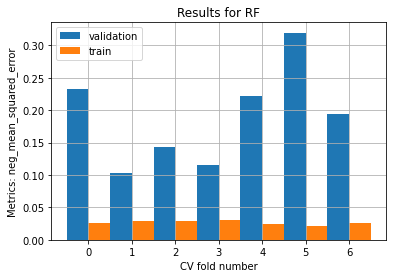

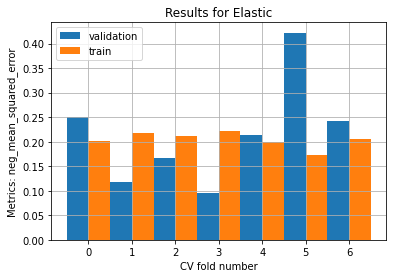

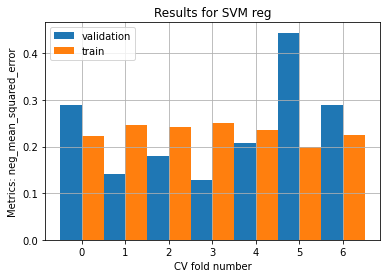

In [34]:
_ = plot_cv_results(
    models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=7,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

- My decision:
    - Random forest better captured the structure of the data (visualizations)
    - However, random forest overfits. Both version with n_estimators = 800 and 200 give approximately same average cross validation result. Hence, I use other model (e.g. Elastic regression)

In [35]:
models

{'elastic_net_final': ElasticNet(alpha=0.5, l1_ratio=0.2),
 'random_forest': RandomForestRegressor(n_estimators=500),
 'RF': RandomForestRegressor(max_depth=11, n_estimators=300),
 'Elastic': ElasticNet(),
 'SVM reg': SVR()}

In [36]:
final_models = {
    'Final': models['elastic_net_final'],
    'RF_final': models['random_forest']
}

In [37]:
path_manager.save_models(
    final_models
)